# Introduction

    In this notebook I will look at datasets from third ASHRAE kaggle competition. The description of the competition and requirements can be found here https://www.kaggle.com/c/ashrae-energy-prediction. The competition provides us with 6 datasets in csv files as follows: Building_metadata.csv, train.csv, test.csv, weather_test.csv, weather_train.csv, sample_submission.csv.
    Before I can start designing a model and build a prototype, I have to make sure that the data provided are clean and of highest possible quality. It is important that data makes sense. It is also important that the data doesn't have unhandled empty values. And the data has to be appropriate size.
    Before we can try to make sense of the data we have to understand the problem we are trying to solve. We are given energy expenditure from multiple building from different site all over the US. Weather and building metadata are provided as well. Base on this information we have to predict future energy expenditure for these buildings. 
    In order to perform the cleaning and wranggling of the data we are going to use pandas. First we need to import all required packages.

# Making sense of the data

In [3]:
import re
import pandas as pd
import datetime

import matplotlib.pyplot as plt

%matplotlib inline

Now, we need to read the csv files into corresponding pandas DataFrames. 

In [2]:
building_md = pd.read_csv('building_metadata.csv')
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
weather_test = pd.read_csv("weather_test.csv")
weather_train = pd.read_csv("weather_train.csv")
sample_submission = pd.read_csv("sample_submission.csv")

First, we are going to explore the building metadata. 

In [3]:
building_md.primary_use.unique()  # there are 16 building types by primary use

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [4]:
building_md.info()  # general information about the building_md table.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [5]:
building_md.site_id.unique() # There are 16 different sites where the buildings are situated 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [6]:
building_md.head()  # First five lines from building_md table. We can already see that some values are missing.

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


Lets explore train table now.

In [8]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


The train data has 4 columns. This is good because there seems to be no redundant columns.

The most important information is contained in the meter_reading column. This is the column that contains the energy meter readings. Meter_readings are reported every hour over a year. Lets see how the meter_reading values look.

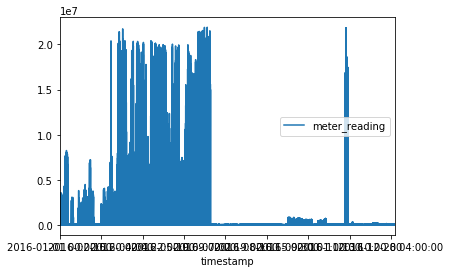

In [11]:
train.plot(x = "timestamp", y = "meter_reading")

Since there are 20 million samples in the dataset, it took around 10 minutes to plot the values of meter_reading column vs. timestamp. 

We can see in the resulting plot that the energy expenditure is not even throughout the year. It also seems that there are some high values that overwhelm the plot. 

Looking back into the train table we notice that there are 4 different meters in use. The meter column has meter IDs. They are meter 0, 1, 2, and 3. Lets try to find whether the high values belong to a certain meter. 

In [12]:
train[train["meter_reading"]>20000000]

,building_id,meter,timestamp,meter_reading
3096856,1099,2,2016-02-27 20:00:00,20392200.0
3098934,1099,2,2016-02-27 21:00:00,20154200.0
3534117,1099,2,2016-03-07 13:00:00,20128200.0
3576101,1099,2,2016-03-08 09:00:00,20812000.0
3578205,1099,2,2016-03-08 10:00:00,21316400.0
...,...,...,...,...
9069340,1099,2,2016-06-16 06:00:00,20482500.0
9076373,1099,2,2016-06-16 09:00:00,20464600.0
17276974,1099,2,2016-11-09 10:00:00,21162700.0
17284060,1099,2,2016-11-09 13:00:00,21821700.0


Indeed, it seems that meter 2 is responsible for the high values on the plot. Lets verify this by splitting out table based on the meter used.

In [13]:
train["meter"].unique()                        # 4 different meters are used

array([0, 3, 1, 2])

In [14]:
meter0 = train[train["meter"] == 0]            # Meter 0 entries

In [15]:
meter0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12060910 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 460.1+ MB


In [16]:
meter1 = train[train["meter"] == 1]            # Meter 1 entries

In [17]:
meter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4182440 entries, 172 to 20216049
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 159.5+ MB


In [18]:
meter2 = train[train["meter"] == 2]          # Meter 2 entries

In [19]:
meter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2708713 entries, 894 to 20216093
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 103.3+ MB


In [20]:
meter3 = train[train["meter"] == 3]           # Meter 3 entries

In [21]:
meter3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264037 entries, 105 to 20215867
Data columns (total 4 columns):
building_id      1264037 non-null int64
meter            1264037 non-null int64
timestamp        1264037 non-null object
meter_reading    1264037 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 48.2+ MB


Lets plot meter0 first.

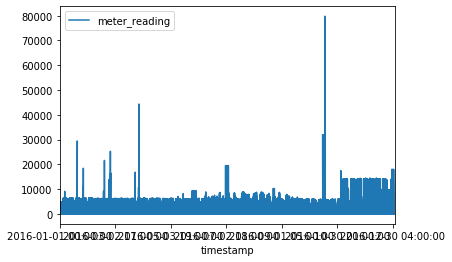

In [23]:
meter0.plot(x = "timestamp", y = "meter_reading")

There is a spike in the plot above. I will treat it as an outlier and delete the row from the original table, just in case.

In [3]:
train.drop(train[train['meter']==0][train['meter_reading']>70000].index.values)

/Users/anyaindman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [24]:
meter0_sample[meter0_sample["meter_reading"]>8000]    # are these outliers or not? I don't know yet, let's leave them for now

,building_id,meter,timestamp,meter_reading
19324740,799,0,2016-12-16 06:00:00,12670.5
19336553,799,0,2016-12-16 11:00:00,14090.8
19348365,799,0,2016-12-16 16:00:00,14090.8




Lets plot meter1

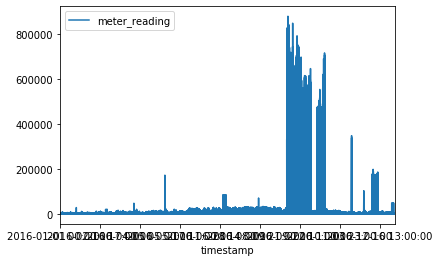

In [26]:
meter1.plot(x = "timestamp", y = "meter_reading")

Finally, lets plot meter2 data. 

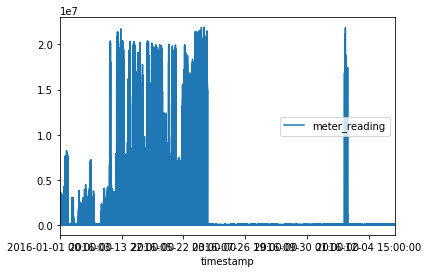

In [27]:
meter2.plot(x = "timestamp", y = "meter_reading")

This plot is almost exactly the same as out very first plot. This proves that the overwhelmingly high values belong to meter 2. 

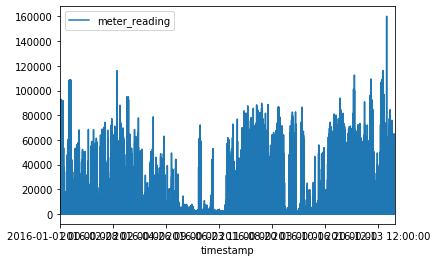

In [28]:
meter3.plot(x = "timestamp", y = "meter_reading")

Now that we don't have other meter values interfering we can see the plot of meter3 more clearly. 

It is intersting to see if we can make sense of why the high values on meter 2 last only for half a year. 

My first thought why this could be the case is the weather. Let's explore the weather-meter_reading correlations

In [91]:
train['air_temp'] = train.merge(weather_train, on =['site_id', 'timestamp'], how = 'left')['air_temperature']

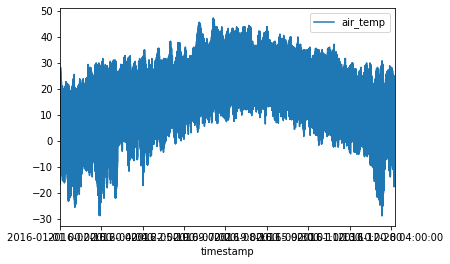

In [35]:
train.plot(x = "timestamp", y = "air_temp")

Temperature graph makes sense, but it does not explain the meter_reading graph

Let's look at distribution of meters in the table, maybe it will explain the shape of the graph

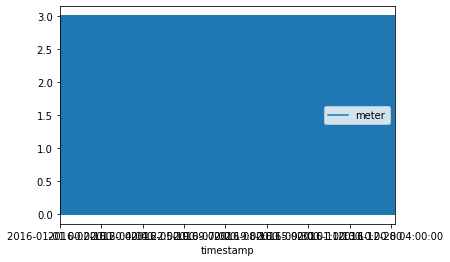

In [36]:
train.plot(x = "timestamp", y = "meter")

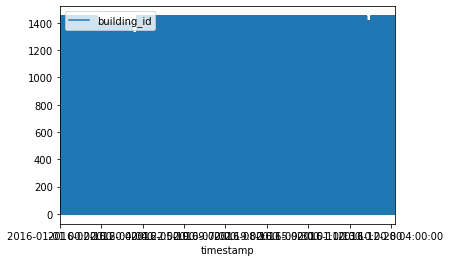

In [37]:
train.plot(x = "timestamp", y = "building_id")

Meter IDs seem to be distributed evenly over the table, let's check site_ids

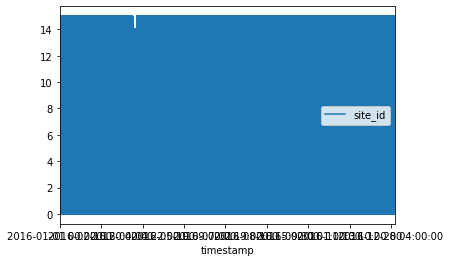

In [38]:
train.plot(x = "timestamp", y = "site_id")

Let's look at distribution of building ids

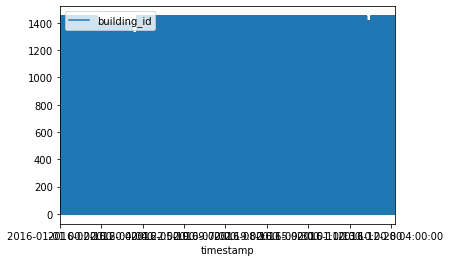

In [39]:
train.plot(x = "timestamp", y = "building_id")

This distribution doesn't provide an explanation either.

Since the shape of the meter_reading distribution resembles 
the shape of meter2 distribution. Let's explore meter2 table. Let's select meter2 rows again to preserve site_id and air_temp columns

Let's explore primary use column

In [92]:
train['primary_use'] = train.merge(building_md, on ='building_id', how = 'left')['primary_use']

In [61]:
train.primary_use.value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

In [62]:
meter2 = train[train['meter']==2]

In [63]:
meter2.primary_use.value_counts()

Education                        1136519
Office                            677872
Lodging/residential               363648
Entertainment/public assembly     242771
Public services                    83882
Healthcare                         77513
Manufacturing/industrial           33820
Food sales and service             17568
Services                           17568
Parking                            17568
Utility                            14944
Other                               8784
Warehouse/storage                   8784
Technology/science                  7472
Name: primary_use, dtype: int64

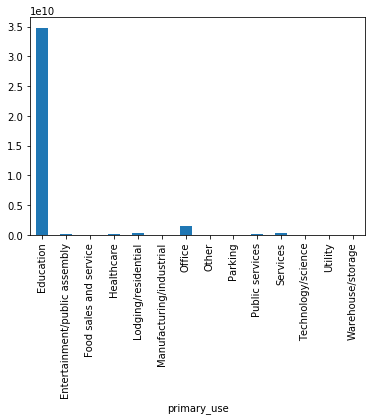

In [68]:
meter2.groupby('primary_use')['meter_reading'].sum().plot(kind= 'bar')

It looks like Education building overwhelm the histogram. 

Lets try to plot meter 2 values without the ones belonging to the education buildings. 

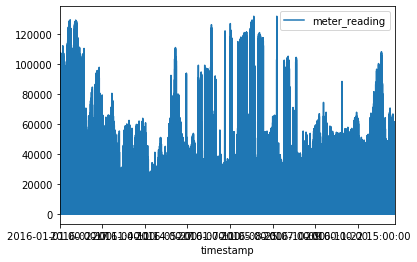

In [71]:
meter2[meter2['primary_use']!='Education'].plot(x = 'timestamp', y = 'meter_reading')

Now, lets try to plot only meter 2 data from educational buildings.

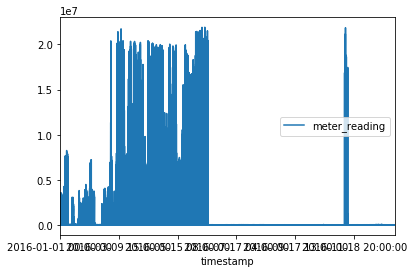

In [72]:
meter2[meter2['primary_use']=='Education'].plot(x='timestamp', y='meter_reading')

We figured out that Education buildings were the ones producing this meter_reading distribution

# Dealing with missing values

Now, lets see if there are any missing values in the train dataset. First we will download it again and exclude the outlier

In [3]:
train = pd.read_csv("train.csv")
train = train.drop(train[train['meter']==0][train['meter_reading']>70000].index.values)

/Users/anyaindman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [18]:
train_null =train.isnull()

In [20]:
train_null[train_null['building_id']==True]

,building_id,meter,timestamp,meter_reading


In [22]:
train_null[train_null['meter']==True]

,building_id,meter,timestamp,meter_reading


In [23]:
train_null[train_null['timestamp']==True]

,building_id,meter,timestamp,meter_reading


So, no missing data in the train table. 





Let's look at building_md

In [72]:
building_md_null = building_md.isnull()

In [73]:
building_md_null

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,False,False,False,False,False,True
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,False,False,False,True
4,False,False,False,False,False,True
...,...,...,...,...,...,...
1444,False,False,False,False,False,True
1445,False,False,False,False,True,True
1446,False,False,False,False,False,True
1447,False,False,False,False,False,True


In [74]:
building_md_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null bool
building_id    1449 non-null bool
primary_use    1449 non-null bool
square_feet    1449 non-null bool
year_built     1449 non-null bool
floor_count    1449 non-null bool
dtypes: bool(6)
memory usage: 8.6 KB


In [75]:
building_md_null[building_md_null['site_id'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [76]:
building_md_null[building_md_null['building_id'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [77]:
building_md_null[building_md_null['primary_use'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [78]:
building_md_null[building_md_null['square_feet'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [79]:
building_md_null[building_md_null['year_built'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
105,False,False,False,False,True,False
106,False,False,False,False,True,False
112,False,False,False,False,True,False
116,False,False,False,False,True,False
127,False,False,False,False,True,False
...,...,...,...,...,...,...
1357,False,False,False,False,True,True
1370,False,False,False,False,True,True
1395,False,False,False,False,True,True
1421,False,False,False,False,True,True


In [80]:
building_md_null[building_md_null['year_built'] == True].count()  # 774 records don't supply "year_built" value

site_id        774
building_id    774
primary_use    774
square_feet    774
year_built     774
floor_count    774
dtype: int64

In [81]:
building_md_null[building_md_null['floor_count'] == True]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,False,False,False,False,False,True
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,False,False,False,True
4,False,False,False,False,False,True
...,...,...,...,...,...,...
1444,False,False,False,False,False,True
1445,False,False,False,False,True,True
1446,False,False,False,False,False,True
1447,False,False,False,False,False,True


In [82]:
building_md_null[building_md_null['floor_count'] == True].count()  # majority of buildings don't have floor counts

site_id        1094
building_id    1094
primary_use    1094
square_feet    1094
year_built     1094
floor_count    1094
dtype: int64

Only year_build and floor_count columns have missing data. I will drop them for the purpose of training. 

In [27]:
building_md_clean = building_md[['site_id', 'building_id', 'primary_use', 'square_feet']]

In [28]:
building_md_clean.to_csv('building_metadata_clean.csv', index=False)  # Writing the new, clean building_metadata csv file

Lets explore the weather_train data

In [5]:
weather_train_null = weather_train.isnull()

In [6]:
weather_train_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null bool
timestamp             139773 non-null bool
air_temperature       139773 non-null bool
cloud_coverage        139773 non-null bool
dew_temperature       139773 non-null bool
precip_depth_1_hr     139773 non-null bool
sea_level_pressure    139773 non-null bool
wind_direction        139773 non-null bool
wind_speed            139773 non-null bool
dtypes: bool(9)
memory usage: 1.2 MB


In [8]:
weather_train_null[weather_train_null['site_id']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [11]:
weather_train_null[weather_train_null['timestamp']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [10]:
weather_train_null[weather_train_null['air_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
368,False,False,True,True,True,False,True,False,False
369,False,False,True,False,True,False,True,False,False
370,False,False,True,False,True,False,True,False,False
15763,False,False,True,True,True,True,True,False,False
22349,False,False,True,True,True,False,True,True,True
27393,False,False,True,False,True,False,True,True,True
30910,False,False,True,True,True,False,True,True,True
30911,False,False,True,True,True,False,True,True,True
30914,False,False,True,False,True,True,True,True,True
50108,False,False,True,True,True,True,True,False,False


In [119]:
weather_train[weather_train_null['air_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
368,0,2016-01-16 08:00:00,NaN,NaN,NaN,0.0,NaN,180.0,1.5
369,0,2016-01-16 09:00:00,NaN,2.0,NaN,0.0,NaN,190.0,1.5
370,0,2016-01-16 10:00:00,NaN,2.0,NaN,0.0,NaN,190.0,1.5
15763,1,2016-10-18 13:00:00,NaN,NaN,NaN,NaN,NaN,290.0,6.2
22349,2,2016-07-19 02:00:00,NaN,NaN,NaN,86.0,NaN,NaN,NaN
27393,3,2016-02-14 07:00:00,NaN,0.0,NaN,0.0,NaN,NaN,NaN
30910,3,2016-07-09 20:00:00,NaN,NaN,NaN,38.0,NaN,NaN,NaN
30911,3,2016-07-09 21:00:00,NaN,NaN,NaN,8.0,NaN,NaN,NaN
30914,3,2016-07-10 00:00:00,NaN,4.0,NaN,NaN,NaN,NaN,NaN
50108,5,2016-09-17 00:00:00,NaN,NaN,NaN,NaN,NaN,310.0,4.6


In [97]:
weather_train_null[weather_train_null['cloud_coverage']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1,False,False,False,True,False,False,False,False,False
5,False,False,False,True,False,False,True,False,False
7,False,False,False,True,False,False,False,False,False
8,False,False,False,True,False,False,False,False,False
9,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
139767,False,False,False,True,False,True,False,False,False
139768,False,False,False,True,False,True,True,False,False
139770,False,False,False,True,False,True,False,False,False
139771,False,False,False,True,False,True,False,False,False


In [98]:
weather_train_null[weather_train_null['dew_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
368,False,False,True,True,True,False,True,False,False
369,False,False,True,False,True,False,True,False,False
370,False,False,True,False,True,False,True,False,False
15763,False,False,True,True,True,True,True,False,False
22349,False,False,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...
115739,False,False,True,True,True,False,True,True,True
126458,False,False,True,True,True,False,True,True,True
136656,False,False,False,False,True,True,False,False,False
137297,False,False,False,True,True,True,False,False,False


In [100]:
weather_train_null[weather_train_null['precip_depth_1_hr']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,False,False,False,False,False,True,False,False,False
8784,False,False,False,True,False,True,False,False,False
8785,False,False,False,False,False,True,False,False,False
8786,False,False,False,False,False,True,False,False,False
8787,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...
139767,False,False,False,True,False,True,False,False,False
139768,False,False,False,True,False,True,True,False,False
139769,False,False,False,False,False,True,False,False,False
139770,False,False,False,True,False,True,False,False,False


In [101]:
weather_train_null[weather_train_null['sea_level_pressure']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
5,False,False,False,True,False,False,True,False,False
26,False,False,False,True,False,False,True,False,False
75,False,False,False,True,False,False,True,False,False
171,False,False,False,True,False,False,True,False,False
187,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...
139559,False,False,False,True,False,True,True,False,False
139560,False,False,False,True,False,True,True,False,False
139561,False,False,False,True,False,True,True,False,False
139562,False,False,False,True,False,True,True,False,False


In [102]:
weather_train_null[weather_train_null['wind_direction']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
163,False,False,False,False,False,False,False,True,False
164,False,False,False,True,False,False,False,True,False
256,False,False,False,False,False,False,False,True,False
428,False,False,False,True,False,False,False,True,False
573,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
138949,False,False,False,True,False,False,False,True,False
139127,False,False,False,True,False,True,False,True,False
139151,False,False,False,True,False,True,False,True,False
139158,False,False,False,False,False,True,False,True,False


In [103]:
weather_train_null[weather_train_null['wind_speed']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
21143,False,False,False,False,False,False,False,True,True
22349,False,False,True,True,True,False,True,True,True
22614,False,False,False,True,False,False,False,False,True
22896,False,False,False,True,False,False,False,True,True
23314,False,False,False,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...
137333,False,False,False,False,False,True,False,True,True
137338,False,False,False,False,False,True,False,True,True
137849,False,False,False,False,False,True,False,True,True
138046,False,False,False,False,False,True,True,True,True


We can see that there is a lot of missing values in weather_train dataset
Lets remove all incomplete data. Lets start with cloud-coverage

In [7]:
weather_train_new = weather_train[weather_train_null['air_temperature']==False][weather_train_null['cloud_coverage']==False][weather_train_null['dew_temperature']==False][weather_train_null['precip_depth_1_hr']==False][weather_train_null['sea_level_pressure']==False][weather_train_null['wind_direction']==False][weather_train_null['wind_speed']==False]




/Users/anyaindman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [8]:
weather_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48780 entries, 2 to 139476
Data columns (total 9 columns):
site_id               48780 non-null int64
timestamp             48780 non-null object
air_temperature       48780 non-null float64
cloud_coverage        48780 non-null float64
dew_temperature       48780 non-null float64
precip_depth_1_hr     48780 non-null float64
sea_level_pressure    48780 non-null float64
wind_direction        48780 non-null float64
wind_speed            48780 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.7+ MB


Check to make sure that there is no more missing values in weather_train_new

In [18]:
weather_train_new_null = weather_train_new.isnull()

In [19]:
weather_train_new_null[weather_train_new_null['air_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [20]:
weather_train_new_null[weather_train_new_null['cloud_coverage']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [21]:
weather_train_new_null[weather_train_new_null['dew_temperature']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [22]:
weather_train_new_null[weather_train_new_null['precip_depth_1_hr']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [23]:
weather_train_new_null[weather_train_new_null['sea_level_pressure']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [24]:
weather_train_new_null[weather_train_new_null['wind_direction']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


In [25]:
weather_train_new_null[weather_train_new_null['wind_speed']==True]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


All clear, no more missing data





In [9]:
weather_train_new.to_csv('weather_train_clean.cvs', index= False)  # writing clean weather train into csv file

In [9]:
weather_train_removed = weather_train[weather_train_null['air_temperature']|weather_train_null['cloud_coverage']|weather_train_null['dew_temperature']|weather_train_null['precip_depth_1_hr']|weather_train_null['sea_level_pressure']|weather_train_null['wind_direction']|weather_train_null['wind_speed']==True]

In [13]:
weather_train_removed.info()       # total of 90993 rows have been removed from weather_train dataset.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90993 entries, 0 to 139772
Data columns (total 9 columns):
site_id               90993 non-null int64
timestamp             90993 non-null object
air_temperature       90938 non-null float64
cloud_coverage        21820 non-null float64
dew_temperature       90880 non-null float64
precip_depth_1_hr     40704 non-null float64
sea_level_pressure    80375 non-null float64
wind_direction        84725 non-null float64
wind_speed            90689 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 6.9+ MB


In [14]:
90993+48780  #Quick check of empty and non-empty add up. Indeed the total number of rows is 139773

139773

Now, we need to remove entries with corresponding timestamp and corresponding site_id from the train table.

In [10]:
train_merged = train

In [11]:
train_merged['site_id']= train_merged.merge(building_md, on = "building_id", how = 'left')['site_id']

In [14]:
train_new= train_merged.merge(weather_train_new, on = ["site_id", "timestamp"], how = 'inner')

In [16]:
train_clean = train_new[['building_id', 'meter', 'timestamp', 'meter_reading']]  # writing train_clean into csv file

In [17]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8955946 entries, 0 to 8955945
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 341.6+ MB


In [26]:
train_clean.to_csv('train_clean.cvs', index= False)

# Selecting a sample from dataset

The dataset is very large, let's select and explore a random sample.

Before we draw a random sample from the train datset we would like to make sure that values from all four kinds of meters are equally represented. For this I will split the dataset according to the meter ID and separately draw random samples from each subtable. From each random sample I will also draw validation sets at random. The number of random samples will be proportional to the number of values for each meter ID. Train-to-validate sets ratios will be 80-to-20. After I have the random samples, I will put them all back together into train_sample and validate_sample datasets and sort them by timestamp.

In [41]:
import numpy as np
import random

In [42]:
train_clean = pd.read_csv('train_clean.cvs')

In [43]:
train_clean_meter0 = train_clean[train_clean['meter']==0]

In [44]:
train_clean_meter0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5233139 entries, 0 to 8955945
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 199.6+ MB


In [45]:
train_clean_meter1 = train_clean[train_clean['meter']==1]

In [46]:
train_clean_meter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981546 entries, 86 to 8955943
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 75.6+ MB


In [47]:
train_clean_meter2 = train_clean[train_clean['meter']==2]

In [48]:
train_clean_meter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059367 entries, 83 to 8955944
Data columns (total 4 columns):
building_id      1059367 non-null int64
meter            1059367 non-null int64
timestamp        1059367 non-null object
meter_reading    1059367 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 40.4+ MB


In [49]:
train_clean_meter3 = train_clean[train_clean['meter']==3]

In [50]:
train_clean_meter3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 681894 entries, 150 to 8954042
Data columns (total 4 columns):
building_id      681894 non-null int64
meter            681894 non-null int64
timestamp        681894 non-null object
meter_reading    681894 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 26.0+ MB


In [51]:
random.seed(100)     # I would like this cell always give same random samples. Therefore, I set seed to a specific number. The number can be any number, as long as it is the same every time you run this cell
# drawing indices at random for each meter. I draw 100 times less values than the original table. 
indices0 = random.sample(range(5233139), 52331)
indices1 = random.sample(range(1981546), 19815)
indices2 = random.sample(range(1059367), 10594)
indices3 = random.sample(range(681894),   6818)

In [52]:
# Selecting rows based on our randomly selected indices. Also, sorting the resulting samples
train_sample0 = train_clean_meter0.iloc[indices0].sort_values("timestamp").reset_index()
train_sample1 = train_clean_meter1.iloc[indices1].sort_values("timestamp").reset_index()
train_sample2 = train_clean_meter2.iloc[indices2].sort_values("timestamp").reset_index()
train_sample3 = train_clean_meter3.iloc[indices3].sort_values("timestamp").reset_index()

In [53]:
# Selecting random indices for validation sets
random.seed(33)
indices0_v = random.sample(range(52331), int(52331*0.2))
indices1_v = random.sample(range(19815), int(19815*0.2))
indices2_v = random.sample(range(10594), int(10594*0.2))
indices3_v = random.sample(range(6818),   int(6818*0.2))

In [54]:
# Selecting validation sets
valid_sample0 = train_sample0.iloc[indices0_v].sort_values("timestamp").reset_index()
valid_sample1 = train_sample1.iloc[indices1_v].sort_values("timestamp").reset_index()
valid_sample2 = train_sample2.iloc[indices2_v].sort_values("timestamp").reset_index()
valid_sample3 = train_sample3.iloc[indices3_v].sort_values("timestamp").reset_index()

In [55]:
# Dropping validation values from the train set
train_sample_new0 = train_sample0.drop(train_sample0.index[indices0_v])
train_sample_new1 = train_sample1.drop(train_sample1.index[indices1_v])
train_sample_new2 = train_sample2.drop(train_sample2.index[indices2_v])
train_sample_new3 = train_sample3.drop(train_sample3.index[indices3_v])

Lets compare distributions and look at ranges

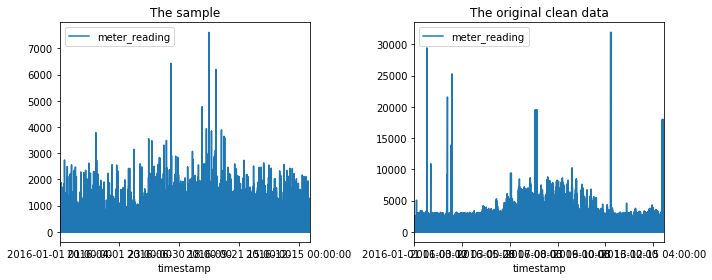

In [56]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
train_sample_new0.plot(x = "timestamp", y = "meter_reading", title = "The sample", ax=ax1)
train_clean_meter0.plot(x = "timestamp", y = "meter_reading", title = "The original clean data", ax=ax2)

plt.tight_layout()

We can see that, even though the random sample for meter 0 skipped a few high values and thus changed the scale, the sample is still acceptable because it does represent the vast majority of the values in the original dataset.  

In [57]:
train_sample_new0['timestamp'].min()

'2016-01-01 01:00:00'

In [58]:
train_sample_new0['timestamp'].max()    # the sample spans the whole year.

'2016-12-31 23:00:00'

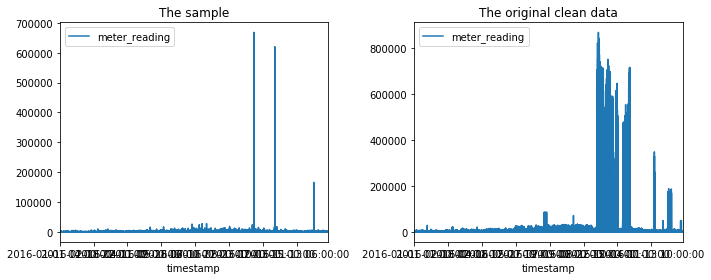

In [59]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
train_sample_new1.plot(x = "timestamp", y = "meter_reading", title = "The sample", ax=ax1)
train_clean_meter1.plot(x = "timestamp", y = "meter_reading", title = "The original clean data", ax=ax2)

plt.tight_layout()

We can see from the plots above that the sample seems to follow the original trend very nicely for meter 1

In [60]:
train_sample_new1['timestamp'].min()

'2016-01-01 04:00:00'

In [61]:
train_sample_new1['timestamp'].max()     # the sample spans the whole year.

'2016-12-31 23:00:00'

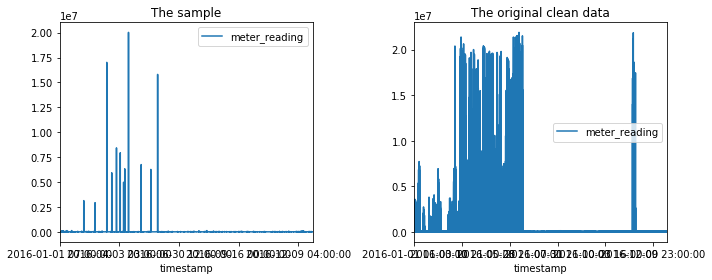

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
train_sample_new2.plot(x = "timestamp", y = "meter_reading", title = "The sample", ax=ax1)
train_clean_meter2.plot(x = "timestamp", y = "meter_reading", title = "The original clean data", ax=ax2)

plt.tight_layout()

Again, trend looks nice

In [87]:
train_sample_new2['timestamp'].min()

'2016-01-01 06:00:00'

In [88]:
train_sample_new2['timestamp'].max()     # the sample spans the whole year.

'2016-12-31 22:00:00'

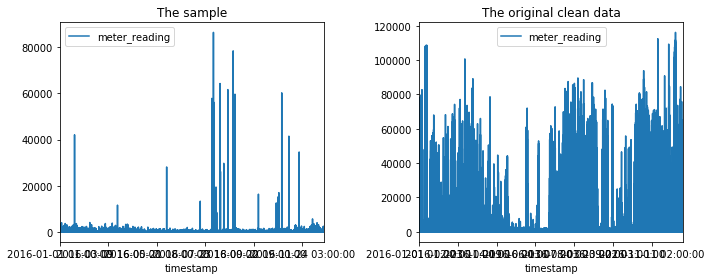

In [63]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
train_sample_new3.plot(x = "timestamp", y = "meter_reading", title = "The sample", ax=ax1)
train_clean_meter3.plot(x = "timestamp", y = "meter_reading", title = "The original clean data", ax=ax2)

plt.tight_layout()

Looks nice for meter 3 as well

In [64]:
train_sample_new3['timestamp'].min()

'2016-01-01 01:00:00'

In [65]:
train_sample_new3['timestamp'].max()    # the sample spans the whole year.

'2016-12-31 21:00:00'

The samples turned out to be looking similar to the original data. Now we need to put them back into 1 dataset

In [67]:
# putting together train sample
train_sample01 = pd.concat([train_sample_new0, train_sample_new1], axis = 0)
train_sample23 = pd.concat([train_sample_new2, train_sample_new3], axis = 0)
train_sample = pd.concat([train_sample01, train_sample23], axis = 0)
train_sample = train_sample.sort_values("timestamp")

In [69]:
# Putting together validation sample
valid_sample01 = pd.concat([valid_sample0, valid_sample1], axis = 0)
valid_sample23 = pd.concat([valid_sample2, valid_sample3], axis = 0)
valid_sample = pd.concat([valid_sample01, valid_sample23], axis = 0)
valid_sample = valid_sample.sort_values("timestamp")

Lets loot at the result

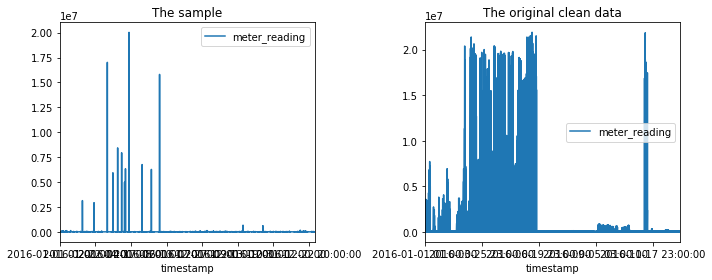

In [68]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
train_sample.plot(x = "timestamp", y = "meter_reading", title = "The sample", ax=ax1)
train_clean.plot(x = "timestamp", y = "meter_reading", title = "The original clean data", ax=ax2)

plt.tight_layout()

In [72]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71648 entries, 0 to 52330
Data columns (total 5 columns):
index            71648 non-null int64
building_id      71648 non-null int64
meter            71648 non-null int64
timestamp        71648 non-null object
meter_reading    71648 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.3+ MB


In [73]:
valid_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17910 entries, 0 to 10465
Data columns (total 6 columns):
level_0          17910 non-null int64
index            17910 non-null int64
building_id      17910 non-null int64
meter            17910 non-null int64
timestamp        17910 non-null object
meter_reading    17910 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 979.5+ KB


Write the resulting dataframes into csv file

In [98]:
train_sample.to_csv('train_sample.csv', index= False)

In [70]:
valid_sample.to_csv('valid_sample.csv', index= False)


# Conclusion

As a result, I can conclude that the dataset ASHRAE provided was of good quality. Nevertheless, some work had to be done to make sure there are no missing values and that the dataset is not too large to use for training. I also had to make sure I have a validation sample to be able to test models I design. 

In addition to that I had to do some exploration to make sense of the data. 

What I found is that splitting train dataset into subsets based on the meter number is a good idea. Working with each meter separately proved to be a wise choice, since every meter has different magnitude of measurements. 

I also found that building_metadata had a lot of missing data in 2 columns (770 out of 1440 buildings missed year they were built and >1000 out of 1440 were missing floor count), so I had to drop these columns, since it was impossible to recreate the data, and if I decided to exclude all the buildings with missing data, more than half of all the buildings would be excluded. (I still have to make sure this was the right decision).

I found that weather data has missing values. I removed them and also removed all observations with corresponding site_ids and timestamps from the train table. 

I didn't find any missing data in the train dataset

Finally, I realized that training with a dataset of 20 million samples would be unpractical. So, I selected a sample at random. From this sample I drew a validation sample. I took care to make sure the trends in training sample matched the trend in the original data. I also made sure that validation set did not repeat any observations of the training set. 

Lastly, I didn't do any modifications to the test datasets since they would need to be submitted for evaluation. 